In [2]:
import torchvision 
import torch 
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [111]:
model = models.resnet50(pretrained=True)

In [112]:
for isim, param in model.named_parameters():
    
    if 'layer4' not in isim:
        param.requires_grad = False

model.fc = torch.nn.Linear(2048, 2) # resenetin çıkışını multilabel yaptım : red and green (fine tunning)

In [3]:
train_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), renkler önemli gray scale yapma
    transforms.Resize((224,224)), # resnet girişi
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])

In [114]:
dataset = datasets.ImageFolder('./dataset', transform=train_transforms)

In [115]:
dataset = datasets.ImageFolder('./dataset', transform = train_transforms)

dataset_boyutu = len(dataset)

egitim_boyutu = int(dataset_boyutu * 0.75)

test_boyutu = dataset_boyutu - egitim_boyutu

egitim_dataset, test_dataset = torch.utils.data.random_split(dataset, [egitim_boyutu, test_boyutu])

print('Dataset boyutu: ', len(dataset))
print('Eğitim boyutu: ', len(egitim_dataset))
print('Test boyutu: ', len(test_dataset))

Dataset boyutu:  1345
Eğitim boyutu:  1008
Test boyutu:  337


In [116]:
egitim_loader = torch.utils.data.DataLoader(egitim_dataset,
                                          batch_size=5,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=5,
                                          shuffle=True)

In [117]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
total_epoch = 100

for epoch in range(total_epoch):
    epoch_loss = 0
    for X, y in egitim_loader:
        
        optimizer.zero_grad()

        cikti = model(X)
        
        loss = criterion(cikti, y)
        
        epoch_loss += loss.item()
        
        loss.backward()

        optimizer.step()
      
    
    dogru = 0
    toplam = 0
    
    #Test
    with torch.no_grad(): #stop regularization
        for X, y in test_loader:
             
            cikti = model(X)
          
            _, maksimum = torch.max(cikti.data, 1)
          
            toplam += y.size(0)
          
            dogru += (maksimum == y).sum().item()
            
            
    
    accuracy = str(dogru/toplam)
    print("[Epoch]:", epoch, "| Training loss:", epoch_loss, "| Accuracy: ", accuracy)
    
    
    #Save the model
    checkpoint = {'model': model,
                        'state_dict': model.state_dict(),
                        'optimizer' : optimizer.state_dict()}
    

    torch.save(checkpoint, 'models/{}.pth'.format(epoch))
    print("Model kaydedildi.")

[Epoch]: 0 | Training loss: 83.95723036769778 | Accuracy:  0.8189910979228486
Model kaydedildi.
[Epoch]: 1 | Training loss: 48.12454981656629 | Accuracy:  0.8753709198813057
Model kaydedildi.
[Epoch]: 2 | Training loss: 40.116989010202815 | Accuracy:  0.9109792284866469
Model kaydedildi.
[Epoch]: 3 | Training loss: 28.32502992497757 | Accuracy:  0.9347181008902077
Model kaydedildi.
[Epoch]: 4 | Training loss: 30.246150315739214 | Accuracy:  0.9228486646884273
Model kaydedildi.
[Epoch]: 5 | Training loss: 14.124052509549074 | Accuracy:  0.9406528189910979
Model kaydedildi.
[Epoch]: 6 | Training loss: 4.569907284047076 | Accuracy:  0.9584569732937686
Model kaydedildi.


#### Accuracy yeterli olduğu için trainingi durdurdum. Kayıtlı modeli kullanıp görsel olarak test ediyorum:

In [25]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    return model.eval()


filepath = "models/6.pth"
model = load_checkpoint(filepath)

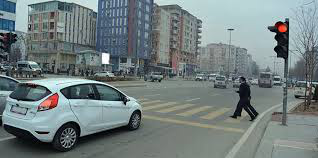

In [17]:
from PIL import Image
from IPython.display import display

red = Image.open('red1.jpg')
display(red)
red = train_transforms(red)
red = red.unsqueeze(0) #dimension expansion

In [18]:
with torch.no_grad():
    out = model(red)
print(out)

tensor([[-4.6444,  4.8437]])


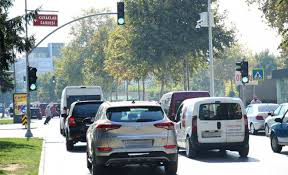

In [21]:
green = Image.open('green1.jpg')
display(green)
green = train_transforms(green)
green = green.unsqueeze(0) #dimensipn expansion

In [22]:
with torch.no_grad():
    out = model(green)
print(out)

tensor([[ 0.5878, -0.4220]])
